In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
!pip install pyccel
!pip install numba
from numba import njit
from pyccel.epyccel import epyccel
from pyccel.decorators import types
import sympy as sp
from matplotlib import pyplot, cm
from mpl_toolkits.mplot3d import Axes3D

     |████████████████████████████████| 245kB 14.5MB/s 
     |████████████████████████████████| 5.9MB 21.3MB/s 
     |████████████████████████████████| 81kB 9.0MB/s 
     |████████████████████████████████| 61kB 7.0MB/s 
  Found existing installation: sympy 1.1.1
    Uninstalling sympy-1.1.1:
      Successfully uninstalled sympy-1.1.1


In [ ]:

def build_up_b_pure(b, rho, dt, u, v, dx, dy):
  row, col = b.shape
  for i in range(1,row-1):
    for j in range(1,col-1):
      b[i,j]=-(rho*((dx)**2)*((dy)**2)/(2*(dx**2+dy**2)))*((1/dt)*((u[i+1,j]-u[i-1,j])/(2*dx)+(v[i,j+1]-v[i,j-1])/(2*dy))-(u[i+1,j]-u[i-1,j])**2/(4*dx**2)-(2/(4*dy*dx))*(u[i,j+1]-u[i,j-1])*(v[i+1,j]-v[i-1,j])-(1/(4*dy**2))*(v[i,j+1]-v[i,j-1])**2)
  return b


def pressure_poisson_pure(p, dx, dy, b):
  pn = np.empty_like(p)
  pn = p.copy()
  row, col = b.shape
  for i in range(1,row-1):
    for j in range(1,col-1):
      p[i,j]=((pn[i+1,j]+pn[i-1,j])*dy**2+(pn[i,j+1]+pn[i,j-1])*dy**2)/(2*(dx**2+dy**2))+b[i,j]

  p[:,0]=p[:,1] #dp/dy=0 at y=0
  p[:,-1]=0   #p=0 at y=2 and x,y in [0,2]
  p[0,:]=p[1,:] #dp/dx=0 at x=0
  p[-1,:]=p[-2,:] #dp/dx=0 at x=2
  return p
  

def cavity_flow_pure(nt, u, v, dt, nx, ny, dx, dy, p, rho, nu):
  u[:,-1]=1   #initial condition at y=2
  un = np.empty_like(u)
  vn = np.empty_like(v)
  b = np.zeros((ny, nx))
  row, col = b.shape
  for k in range(nt):
    un=u.copy()
    vn=v.copy()
    for i in range(1,row-1):
      for j in range(1,col-1):
        u[i,j]=un[i,j]-un[i,j]*(dt/dx)*(un[i,j]-un[i-1,j])-vn[i,j]*(dt/dy)*(un[i,j]-un[i,j-1])-(dt/(rho*2*dx))*(p[i+1,j]-p[i-1,j])+nu*((dt/dx**2)*(un[i+1,j]-2*un[i,j]+un[i-1,j])+(dt/dy**2)*(un[i,j+1]-2*un[i,j]+un[i,j-1]))
        v[i,j]=vn[i,j]-un[i,j]*(dt/dx)*(vn[i,j]-vn[i-1,j])-vn[i,j]*(dt/dy)*(vn[i,j]-vn[i,j-1])-(dt/(rho*2*dx))*(p[i,j+1]-p[i,j-1])+nu*((dt/dx**2)*(vn[i+1,j]-2*vn[i,j]+vn[i-1,j])+(dt/dy**2)*(vn[i,j+1]-2*vn[i,j]+vn[i,j-1]))
    b=build_up_b_pure(b, rho, dt, u, v, dx, dy)
    p=pressure_poisson_pure(p, dx, dy, b)
         
  return u,v,p

In [ ]:
@njit
def build_up_b_numba(b, rho, dt, u, v, dx, dy):
  row, col = b.shape
  for i in range(1,row-1):
    for j in range(1,col-1):
      b[i,j]=-(rho*((dx)**2)*((dy)**2)/(2*(dx**2+dy**2)))*((1/dt)*((u[i+1,j]-u[i-1,j])/(2*dx)+(v[i,j+1]-v[i,j-1])/(2*dy))-(u[i+1,j]-u[i-1,j])**2/(4*dx**2)-(2/(4*dy*dx))*(u[i,j+1]-u[i,j-1])*(v[i+1,j]-v[i-1,j])-(1/(4*dy**2))*(v[i,j+1]-v[i,j-1])**2)
  return b

@njit
def pressure_poisson_numba(p, dx, dy, b):
  pn = np.empty_like(p)
  pn = p.copy()
  row, col = b.shape
  for i in range(1,row-1):
    for j in range(1,col-1):
      p[i,j]=((pn[i+1,j]+pn[i-1,j])*dy**2+(pn[i,j+1]+pn[i,j-1])*dy**2)/(2*(dx**2+dy**2))+b[i,j]

  p[:,0]=p[:,1] #dp/dy=0 at y=0
  p[:,-1]=0   #p=0 at y=2 and x,y in [0,2]
  p[0,:]=p[1,:] #dp/dx=0 at x=0
  p[-1,:]=p[-2,:] #dp/dx=0 at x=2
  return p

@njit
def cavity_flow_numba(nt, u, v, dt, nx, ny, dx, dy, p, rho, nu):
  u[:,-1]=1   #initial condition at y=2
  un = np.empty_like(u)
  vn = np.empty_like(v)
  b = np.zeros((ny, nx))
  row, col = b.shape
  for k in range(nt):
    un=u.copy()
    vn=v.copy()
    for i in range(1,row-1):
      for j in range(1,col-1):
        u[i,j]=un[i,j]-un[i,j]*(dt/dx)*(un[i,j]-un[i-1,j])-vn[i,j]*(dt/dy)*(un[i,j]-un[i,j-1])-(dt/(rho*2*dx))*(p[i+1,j]-p[i-1,j])+nu*((dt/dx**2)*(un[i+1,j]-2*un[i,j]+un[i-1,j])+(dt/dy**2)*(un[i,j+1]-2*un[i,j]+un[i,j-1]))
        v[i,j]=vn[i,j]-un[i,j]*(dt/dx)*(vn[i,j]-vn[i-1,j])-vn[i,j]*(dt/dy)*(vn[i,j]-vn[i,j-1])-(dt/(rho*2*dx))*(p[i,j+1]-p[i,j-1])+nu*((dt/dx**2)*(vn[i+1,j]-2*vn[i,j]+vn[i-1,j])+(dt/dy**2)*(vn[i,j+1]-2*vn[i,j]+vn[i,j-1]))
    b=build_up_b_numba(b, rho, dt, u, v, dx, dy)
    p=pressure_poisson_numba(p, dx, dy, b)
         
  return u,v,p

In [ ]:
@types('int','float[:,:]','float[:,:]','float[:,:]','float[:,:]','float','int','int','float','float','float[:,:]','float[:,:]','float','float','float[:,:]')
def cavity_flow_pyccel(nt, u,un,vn ,v, dt, nx, ny, dx, dy, p,pn, rho, nu,b):

  @types('float[:,:]','float','float','float[:,:]','float[:,:]','float','float')
  def build_up_b_pyccel(b, rho, dt, u, v, dx, dy):
    rowb, colb = b.shape
    for i in range(1,rowb-1):
      for j in range(1,colb-1):
        b[i,j]=-(rho*((dx)**2)*((dy)**2)/(2*(dx**2+dy**2)))*((1/dt)*((u[i+1,j]-u[i-1,j])/(2*dx)+(v[i,j+1]-v[i,j-1])/(2*dy))-(u[i+1,j]-u[i-1,j])**2/(4*dx**2)-(2/(4*dy*dx))*(u[i,j+1]-u[i,j-1])*(v[i+1,j]-v[i-1,j])-(1/(4*dy**2))*(v[i,j+1]-v[i,j-1])**2)
    return 0

  @types('float[:,:]','float[:,:]','float','float','float[:,:]')
  def pressure_poisson_pyccel(p,pn, dx, dy, b):
    #pn = np.empty_like(p)
    #pn = p.copy()
    rowp, colp = p.shape
    for i in range(rowp):
      for j in range(colp):
        pn[i,j]=p[i,j]
    row, col = b.shape
    for i in range(1,row-1):
      for j in range(1,col-1):
        p[i,j]=((pn[i+1,j]+pn[i-1,j])*dy**2+(pn[i,j+1]+pn[i,j-1])*dy**2)/(2*(dx**2+dy**2))+b[i,j]

    p[:,0]=p[:,1] #dp/dy=0 at y=0
    p[:,-1]=0   #p=0 at y=2 and x,y in [0,2]
    p[0,:]=p[1,:] #dp/dx=0 at x=0
    p[-1,:]=p[-2,:] #dp/dx=0 at x=2
    return 0


  u[:,-1]=1   #initial condition at y=2
  #un = np.empty_like(u)
  #vn = np.empty_like(v)
  #b = np.zeros((ny, nx))
  row1, col1 = u.shape
  for i in range(row1):
    for j in range(col1):
      un[i,j]=u[i,j]
      vn[i,j]=v[i,j]
  row, col = b.shape
  for k in range(nt):
    #un=u.copy()
    #vn=v.copy()
    for i in range(row1):
      for j in range(col1):
        un[i,j]=u[i,j]
        vn[i,j]=v[i,j]
    for i in range(1,row-1):
      for j in range(1,col-1):
        u[i,j]=un[i,j]-un[i,j]*(dt/dx)*(un[i,j]-un[i-1,j])-vn[i,j]*(dt/dy)*(un[i,j]-un[i,j-1])-(dt/(rho*2*dx))*(p[i+1,j]-p[i-1,j])+nu*((dt/dx**2)*(un[i+1,j]-2*un[i,j]+un[i-1,j])+(dt/dy**2)*(un[i,j+1]-2*un[i,j]+un[i,j-1]))
        v[i,j]=vn[i,j]-un[i,j]*(dt/dx)*(vn[i,j]-vn[i-1,j])-vn[i,j]*(dt/dy)*(vn[i,j]-vn[i,j-1])-(dt/(rho*2*dx))*(p[i,j+1]-p[i,j-1])+nu*((dt/dx**2)*(vn[i+1,j]-2*vn[i,j]+vn[i-1,j])+(dt/dy**2)*(vn[i,j+1]-2*vn[i,j]+vn[i,j-1]))
    build_up_b_pyccel(b, rho, dt, u, v, dx, dy)
    pressure_poisson_pyccel(p, dx, dy, b)
         
  return 0

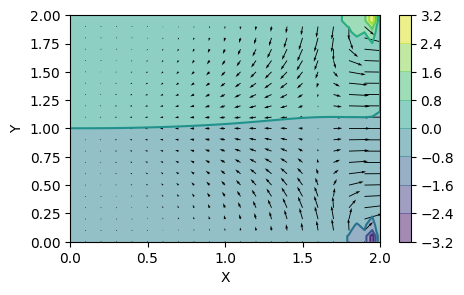

In [ ]:
nx = 41
ny = 41
nt = 500
nit = 50
c = 1
dx = 2 / (nx - 1)
dy = 2 / (ny - 1)
x = np.linspace(0, 2, nx)
y = np.linspace(0, 2, ny)
X, Y = np.meshgrid(x, y)

rho = 1
nu = .1
dt = .001

u = np.zeros((ny, nx))
v = np.zeros((ny, nx))
p = np.zeros((ny, nx)) 
b = np.zeros((ny, nx))

u, v, p = cavity_flow_numba(nt, u, v, dt, nx, ny, dx, dy, p, rho, nu)

fig = pyplot.figure(figsize=(5, 3), dpi=100)
pyplot.contourf(X, Y, p, alpha=0.5, cmap=cm.viridis)
pyplot.colorbar()
pyplot.contour(X, Y, p, cmap=cm.viridis)
pyplot.quiver(X[::2, ::2], Y[::2, ::2], u[::2, ::2], v[::2, ::2])
pyplot.xlabel('X')
pyplot.ylabel('Y');


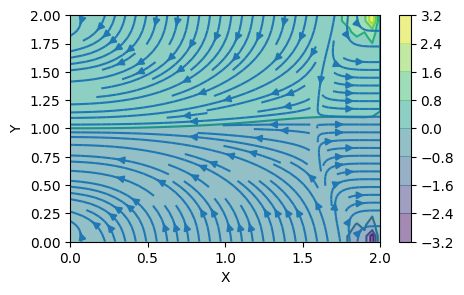

In [ ]:
fig = pyplot.figure(figsize=(5, 3), dpi=100)
pyplot.contourf(X, Y, p, alpha=0.5, cmap=cm.viridis)
pyplot.colorbar()
pyplot.contour(X, Y, p, cmap=cm.viridis)
pyplot.streamplot(X, Y, u, v)
pyplot.xlabel('X')
pyplot.ylabel('Y');

In [ ]:

%timeit cavity_flow_pure(nt, u, v, dt, ny, ny, dx, dy, p, rho, nu)


1 loop, best of 3: 21.3 s per loop


In [ ]:
%timeit cavity_flow_numba(nt, u, v, dt, ny, ny, dx, dy, p, rho, nu)

100 loops, best of 3: 15.6 ms per loop


In [ ]:
z

In [ ]:
cavity_flow_pyccel_90=epyccel(cavity_flow_pyccel)


ERROR at Fortran compilation stage


CalledProcessError: ignored

In [ ]:
%timeit cavity_flow_pyccel_90(nt, u,un,vn ,v, dt, nx, ny, dx, dy, p, rho, nu)